In [56]:
import random
import numpy as np
import re 
import copy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [57]:
def encrypt(plaintext, plaintext_alphabet ,cipher_alphabet, blacklist={}):
    assert set(list(plaintext)).difference(blacklist).issubset(set(list(plaintext_alphabet))), "Plaintext must only contain characters in Plaintext alphabet"
    assert len(plaintext_alphabet) == len(cipher_alphabet), "Cipher alphabet must have same number of characters as Plaintext alphabet"

    enc_key = dict(zip(list(plaintext_alphabet),list(cipher_alphabet)))
    acc = []
    for s in plaintext:
        if s in blacklist:
            acc += s
        else:
            acc += [enc_key[s]]
    ciphertext = "".join(acc)

    return {'cipher_alphabet' : cipher_alphabet,
            'plaintext_alphabet' : plaintext_alphabet,
            'ciphertext' : ciphertext,
           }

def decrypt(ciphertext, plaintext_alphabet, cipher_alphabet, blacklist={}):
    dec_key = dict(zip(list(cipher_alphabet),list(plaintext_alphabet)))
    acc = []
    for s in ciphertext:
        
        if s in blacklist:
            acc += [s]
        else:
            acc += [dec_key[s]]
    plaintext = "".join(acc)
    return {'cipher_alphabet' : cipher_alphabet,
            'plaintext_alphabet' : plaintext_alphabet,
            'plaintext' : plaintext,
           }

In [58]:
def process_text(filename, regex_ignore='[^A-Z .]', regularize=True):
    char_bigram_counts = Counter()
    char_unigram_counts = Counter()

    with open(filename,encoding='utf-8') as f:
        cnt = 0
        for line in f:
            cnt += 1
            if cnt % 5000 == 0: print("{0} lines read.".format(cnt))
            if regex_ignore != None:
                pattern = re.compile(regex_ignore)
                s = pattern.sub('',line.upper())
            else:
                s = line.upper()

            line_length = len(s)

            if line_length > 0:
                for i in range(line_length-1):
                    char_bigram_counts[(s[i],s[i+1])] +=1
                    char_unigram_counts[s[i]] += 1

                char_unigram_counts[s[line_length-1]] += 1 
                

    i_c_map = dict(enumerate([q[0] for q in sorted(list(char_unigram_counts.items()),key=lambda x: x[0])]))
    c_i_map = {v: k for k, v in i_c_map.items()}

    n = len(c_i_map)
    M = np.zeros((n,n))
    if regularize:
        M += 1
        
    for k in char_bigram_counts.keys():
        M[c_i_map[k[0]]][c_i_map[k[1]]] = char_bigram_counts[k]

    zero_rows = np.where(M.sum(axis=1) == 0.)
    M[zero_rows,:] = 1
    row_sums = M.sum(axis=1)
    P = M / row_sums[:,np.newaxis]

    print('{0} uniform row(s) inputed for characters {1}'.format(zero_rows[0].size, 
                                                                [i_c_map[z] for z in zero_rows[0]]))

    return {'char_bigram_counts': char_bigram_counts,
            'char_unigram_counts': char_unigram_counts,
            'bigram_freq_matrix': M,
            'transition_matrix': P,
            'character_index_map': c_i_map,
            'index_character_map': i_c_map,
           }

In [59]:
def plausibility(f, char_index_map, cipher, transition_mtx, blacklist={}, print_output=False):
    n = len(cipher)
    probs = np.zeros(n-1)
    q = len(transition_mtx)
    k = []
    v = []
    
    for i,j in f.items():
        k += [i]
        v += [j]
        
    dec = decrypt(cipher,"".join(v),"".join(k),blacklist)['plaintext']
    for i in range(n-1):
        if dec[i] in blacklist or dec[i+1] in blacklist:    
            probs[i] = 1/q
        else:
            probs[i] = transition_mtx[c_i_map[dec[i]]][c_i_map[dec[i+1]]]
            
        # Ensures numerical stability
        probs_sorted = np.sort(probs,kind='quicksort')

    return {"score":np.sum(np.log(np.array(probs))),"attempt":dec} 
def similarity(s1, s2):
    assert len(s1) == len(s2), "Both strings must be same length"
    n = len(s1)
    num_matches = sum([1 if a == b else 0 for a,b in zip(s1,s2)])
    return num_matches/n    

In [60]:
def solve_mcmc(ciphertext, usual_alphabet,code_space, trans_mtx, char_index_mapping, iters=2500, skip_chars={}):
    f = dict(zip(list(code_space),list(usual_alphabet)))
    
    scores = [0.0]*iters
    mappings = []
    accepted = 0
    for i in range(0,iters):

        mappings += [f]

        # Create proposal from f by random transposition of 2 letters
        r1, r2 = np.random.choice(list(code_space),2,replace=True)
        f_proposal = f.copy()
        f_proposal[r1] = f[r2]
        f_proposal[r2] = f[r1]

        current = plausibility(f,char_index_mapping,ciphertext,trans_mtx,blacklist=skip_chars)
        f_prob = current['score']
        
 
        if i % 500 == 0: 
            print("iter:", i,current['attempt'][:100])

        f_proposal_prob = plausibility(f_proposal,char_index_mapping,ciphertext,trans_mtx,blacklist=skip_chars)['score']

        # Decide to accept new proposal
        u = random.uniform(0,1)
        if f_proposal_prob > f_prob:
            f = f_proposal.copy()
            scores[i] = f_proposal_prob
            accepted += 1
        elif u < np.exp(f_proposal_prob - f_prob):
            f = f_proposal.copy()
            scores[i] = f_proposal_prob
            accepted += 1
        scores[i] = f_prob

    print("total acceptances: ", accepted)

    best_f = mappings[np.argmax(scores)]
    best_score = max(scores)
    plains = []
    ciphers = []

    for k in sorted(best_f.keys()):
        ciphers += [k]
        plains += [best_f[k]]
    
    best_key = ("".join(plains),"".join(ciphers))
    best_attempt = decrypt(ciphertext,best_key[0],best_key[1],blacklist=skip_chars)['plaintext']
    
    print("score:",best_score)
    return {'num_iters':iters,
            'plaintext':best_attempt,
            'best_score':best_score,
            'best_key':best_f,
            'scores':scores,
            'total_acceptances': accepted
            }

In [61]:
test_pattern = '[^A-Z ]'
pattern = re.compile(test_pattern)
message = "ENTER HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE OR TO TAKE ARMS AGAINST A SEA OF TROUBLES AND BY OPPOSING END"
message_cleaned = pattern.sub('',message.upper())

en_alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ "
tmp = list(en_alphabet)
random.shuffle(tmp)
cipher_alphabet = "".join(tmp)
message_enc = encrypt(message_cleaned,en_alphabet,cipher_alphabet,)
ciphertext = message_enc['ciphertext']
print(message_enc)
print(decrypt(message_enc['ciphertext'],en_alphabet, cipher_alphabet,))
print((en_alphabet,cipher_alphabet))
results = process_text('credit_card.txt',regex_ignore=test_pattern)
P = results['transition_matrix']
F = results['bigram_freq_matrix']
m = P.shape[0]
i_c_map = results['index_character_map']
c_i_map = results['character_index_map']


{'cipher_alphabet': 'NDFEUR BAYJPLWQKCMZIXSHVTGO', 'plaintext_alphabet': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ ', 'ciphertext': 'UWIUMOBNLPUIOIQODUOQMOWQIOIQODUOIBNIOAZOIBUOCXUZIAQWOHBUIBUMOIAZOWQDPUMOAWOIBUOLAWEOIQOZXRRUMOIBUOZPAW ZONWEONMMQHZOQROQXIMN UQXZORQMIXWUOQMOIQOINJUONMLZON NAWZIONOZUNOQROIMQXDPUZONWEODTOQKKQZAW OUWE'}
{'cipher_alphabet': 'NDFEUR BAYJPLWQKCMZIXSHVTGO', 'plaintext_alphabet': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ ', 'plaintext': 'ENTER HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE OR TO TAKE ARMS AGAINST A SEA OF TROUBLES AND BY OPPOSING END'}
('ABCDEFGHIJKLMNOPQRSTUVWXYZ ', 'NDFEUR BAYJPLWQKCMZIXSHVTGO')
0 uniform row(s) inputed for characters []


Text(0.5, 1.0, 'Character Transition Matrix (Ecommerce)')

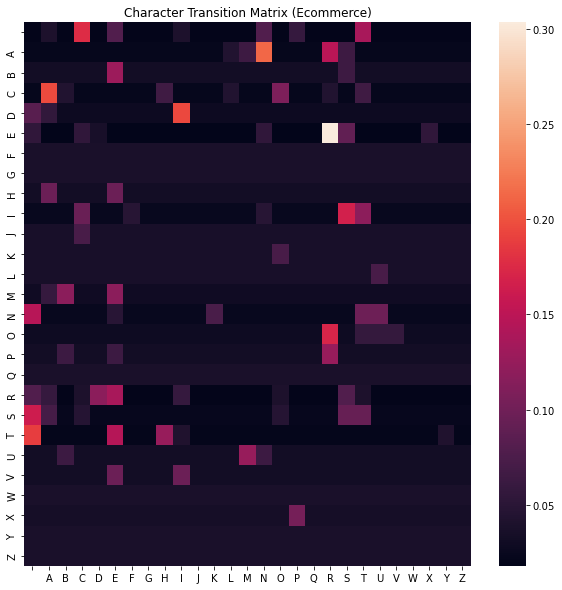

In [62]:
names = []
for k in sorted(list(i_c_map.keys())):
    names += [i_c_map[k]]
    
plt.figure(figsize=(10,10))
sns.heatmap(P,xticklabels=names,yticklabels=names)
plt.title("Character Transition Matrix (Ecommerce)")

In [63]:
init = list(en_alphabet).copy()
random.shuffle(init)
print("ciphertext:")
print(ciphertext)

print()
soln = solve_mcmc(ciphertext,en_alphabet,init,P,c_i_map,iters=5000)
print()

print("attempted decryption:")
print(soln['plaintext'])
print()
print("original message:")
print(message_cleaned)
ground_truth_score = plausibility(dict(zip(cipher_alphabet,en_alphabet)),c_i_map,ciphertext,P)

print()
print('score of true key:', ground_truth_score['score'])
print('similarity score:', similarity(message_cleaned, soln['plaintext']))

ciphertext:
UWIUMOBNLPUIOIQODUOQMOWQIOIQODUOIBNIOAZOIBUOCXUZIAQWOHBUIBUMOIAZOWQDPUMOAWOIBUOLAWEOIQOZXRRUMOIBUOZPAW ZONWEONMMQHZOQROQXIMN UQXZORQMIXWUOQMOIQOINJUONMLZON NAWZIONOZUNOQROIMQXDPUZONWEODTOQKKQZAW OUWE

iter: 0 TZGTDLIMAQTGLGYLVTLYDLZYGLGYLVTLGIMGLNULGITLPWTUGNYZLKITGITDLGNULZYVQTDLNZLGITLANZFLGYLUWCCTDLGITLUQ
iter: 500 C UCONITZSCUNUKNFCNKON KUNUKNFCNUITUNRANUICNPWCAURK NDICUICONURAN KFSCONR NUICNZR ENUKNAWLLCONUICNAS
iter: 1000 C UCONITGZCUNUKNXCNKON KUNUKNXCNUITUNRANUICNQLCAURK NDICUICONURAN KXZCONR NUICNGR ENUKNALSSCONUICNAZ
iter: 1500 S KSONITVESKNKUNBSNUON UKNKUNBSNKITKNRANKISNGMSAKRU NCISKISONKRAN UBESONR NKISNVR PNKUNAMFFSONKISNAE
iter: 2000 S USONITHESUNUKNBSNKON KUNUKNBSNUITUNRANUISNLMSAURK NDISUISONURAN KBESONR NUISNHR CNUKNAMWWSONUISNAE
iter: 2500 S KSONITHESKNKUNBSNUON UKNKUNBSNKITKNRANKISNVMSAKRU NDISKISONKRAN UBESONR NKISNHR PNKUNAMXXSONKISNAE
iter: 3000 S KSONITQESKNKUNBSNUON UKNKUNBSNKITKNRANKISNYMSAKRU NDISKISONKRAN UBESONR NKISNQR PNKUNAMZZSONKISNAE
iter: 3

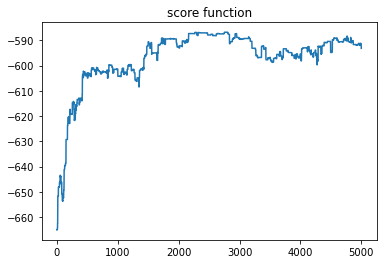

In [64]:
plt.plot(soln['scores'])
plt.title('score function')
plt.show()  